In [1]:
import sys
import os 
import pandas as pd
import numpy as np

current_directory = os.getcwd()
sys.path.append(current_directory)

from py_modules.data_cleaner import DataCleaner

### **Load Data**

In [2]:
annual_data = pd.read_excel('Annual Financial Data (No Extra Columns).xlsx')
quarterly_data = pd.read_excel('Quarterly Financial Data (No Extra Columns).xlsx')


**Drop Macroeconomic Indicators due to Drift Risks**

In [3]:
macroeconomic_indicators = ['FEDFUNDS',
                            'Average hourly earnings',
                            'Producer Price Index',
                            'Unemployment Rate, Percent, Monthly, Seasonally Adjusted',
                            'Labor Market Tightness',
                            'Job Openings: Total Nonfarm, Rate, Monthly, Seasonally Adjusted',
                            'Unemployment Rate (Computers and electronic products)',
                            'Number of Employees (Computer and electronic product manufacturing)',
                            'Unnamed: 0']

annual_data.drop(columns=macroeconomic_indicators, inplace=True)
quarterly_data.drop(columns=macroeconomic_indicators, inplace=True)

### **Clean & Filter**
#### **Annual Data**

In [4]:
annual_cleaner = DataCleaner(annual_data, variable_of_interest='Employees')
annual_summary = annual_cleaner.summarize_columns()
annual_correlation_summary = annual_cleaner.correlation()

annual_correlation_summary.rename(columns={'index': 'Variable'}, inplace=True)

annual_correlation_summary = annual_correlation_summary.where(annual_correlation_summary[
    '% Nan Values']<0.5).dropna().sort_values(by='% Nan Values', ascending=False).reset_index()

/Users/alexanderperalta/anaconda3/envs/finance_project/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/alexanderperalta/anaconda3/envs/finance_project/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


#### **Quarterly Data**

In [5]:
quarterly_cleaner = DataCleaner(quarterly_data, variable_of_interest='Employees')
quarterly_summary = quarterly_cleaner.summarize_columns()

quarterly_summary = quarterly_summary.where(quarterly_summary[
    '% Nan Values']<0.1).dropna().sort_values(by='% Nan Values', ascending=False).reset_index()

quarterly_columns = list(quarterly_summary['index'].unique())
quarterly_data = quarterly_data[quarterly_columns].dropna()
quarterly_data.drop(columns={'Preferred ESOP Obligation - Total', 
                             'Preferred ESOP Obligation - Redeemable', 
                             'Preferred ESOP Obligation - Non-Redeemable'}, inplace=True)

#### **Find intersection of columns**

In [6]:
len(list(annual_data.columns)) > len(list(quarterly_data.columns))

True

In [7]:
annual_identifiers = ['Global Company Key', 'Company Name', 'Date', 'Ticker Symbol', 'Employees']

quarterly_dates = {'Fiscal Data Year and Quarter', 'Fiscal Quarter', 'Fiscal Year'}
quarterly_columns_new = [item for item in quarterly_columns if item not in quarterly_dates]
annual_columns = list(set(annual_identifiers).union(set(quarterly_columns_new)))
annual_data = annual_data[annual_columns].dropna()
annual_data.drop(columns={'Preferred ESOP Obligation - Total', 
                             'Preferred ESOP Obligation - Redeemable', 
                             'Preferred ESOP Obligation - Non-Redeemable'}, inplace=True)

In [8]:
quarterly_identifiers = list(quarterly_dates) + ['Global Company Key', 'Company Name', 'Date', 'Ticker Symbol']

In [9]:
cols1 = set(quarterly_data.columns)
cols2 = set(annual_data.columns)

# 1. Check if they are identical
identical = cols1 == cols2

# 2. Find columns in quarterly_data but not in annual_data
missing_in_annual_data = cols1 - cols2
print(missing_in_annual_data)

# 3. Find columns in annual_data but not in quarterly_data
missing_in_quarterly_data = cols2 - cols1
print(missing_in_quarterly_data)

{'Fiscal Quarter', 'Fiscal Data Year and Quarter', 'Fiscal Year'}
{'Employees'}


In [10]:
metric_columns = ['Sales/Turnover (Net)', 'Operating Income After Depreciation', 
                  'Net Income (Loss)', 'Selling, General and Administrative Expenses', 
                  'Cost of Goods Sold', 'Depreciation and Amortization', 
                  'Common/Ordinary Equity - Total', 'Assets - Total', 
                  'Liabilities - Total', 'Long-Term Debt - Total', 
                  'Current Liabilities - Total', 'Current Assets - Total',
                  'Inventories - Total', 'Cash and Short-Term Investments', 
                  'Intangible Assets - Total', 'Receivables - Total']

### **Jensen-Shannon Divergence**

Compute the Jensen-Shannon distance (metric) between two probability arrays. This is the square root of the Jensen-Shannon divergence.

The Jensen-Shannon distance between two probability vectors p and q is defined as,

$$\sqrt{\frac{D(p \parallel m) + D(q \parallel m)}{2}}$$

where $m$ is the pointwise mean of $q$ and $d$ and $D$ is the Kullback-Leibler divergence.

This routine will normalize $p$ and $q$ if they don’t sum to 1.0.

In [11]:
from scipy.spatial.distance import jensenshannon

def get_feature_report(df1, df2):
    # 1. Identify shared columns
    common_cols = list(set(df1.columns) & set(df2.columns))
    report = []

    for col in common_cols:
        # Skip non-numeric columns for distance calculation
        if not np.issubdtype(df1[col].dtype, np.number):
            continue
            
        # 2. Align bins for JS Distance
        combined_min = min(df1[col].min(), df2[col].min())
        combined_max = max(df1[col].max(), df2[col].max())
        
        # 3. Create probability distributions
        p, _ = np.histogram(df1[col], bins=100, range=(combined_min, combined_max), density=True)
        q, _ = np.histogram(df2[col], bins=100, range=(combined_min, combined_max), density=True)
        
        # 4. Calculate JS Distance
        js_dist = jensenshannon(p, q)
        
        report.append({
            'Column': col,
            'JS_Distance': js_dist,
            'Mean_Diff_Pct': abs(df1[col].mean() - df2[col].mean()) / (df1[col].mean() + 1e-9),
            'Status': 'Stable' if js_dist < 0.2 else ('Warning' if js_dist < 0.4 else 'Drifted')
        })

    return pd.DataFrame(report).sort_values('JS_Distance')

stability_report = get_feature_report(annual_data, quarterly_data)
stability_report = stability_report.where(stability_report['Status']=='Drifted').dropna()

stability_report

,Column,JS_Distance,Mean_Diff_Pct,Status


### **Adversarial Validation**

The objective of any predictive modelling project is to create a model using the training data, and afterwards apply this model to the test data. However, for the best results it is essential that the training data is a representative sample of the data we intend to use it on (i.e. the test data), otherwise our model will, at best, under-perform, or at worst, be completely useless.

Adversarial Validation is a very clever and very simple way to let us know if our test data and our training data are similar; we combine our train and test data, labeling them with say a 0 for the training data and a 1 for the test data, mix them up, then see if we are able to correctly re-identify them using a binary classifier.

If we cannot correctly classify them, i.e. we obtain an area under the receiver operating characteristic curve (ROC) of 0.5 then they are indistinguishable and we are good to go.

However, if we can classify them (ROC > 0.5) then we have a problem, either with the whole dataset or more likely with some features in particular, which are probably from different distributions in the test and train datasets. If we have a problem, we can look at the feature that was most out of place. The problem may be that there were values that were only seen in, say, training data, but not in the test data. If the contribution to the ROC is very high from one feature, it may well be a good idea to remove that feature from the model.

**Adversarial Validation to reduce overfitting**

The key to avoid overfitting is to create a situation where the local cross-vlidation (CV) score is representative of the competition score. When we have a ROC of 0.5 then your local data is representative of the test data, thus your local CV score should now be representative of the Public LB score.

Procedure:
- drop the training data target column
- label the test and train data with 0 and 1 (it doesn't really matter which is which)
- combine the training and test data into one big dataset
- perform the binary classification, for example using XGboost
- look at our AUC ROC score

We shall look at two examples of adversarial validation. Note: For the purposes of these demonstrations we shall only be using the numeric features.



In [12]:
import xgboost as xgb

# select only the numerical features
X_test  = quarterly_data.select_dtypes(include=['number']).copy()
X_train = annual_data.select_dtypes(include=['number']).copy()

# drop the target column from the training data
#X_train = X_train.drop(['Survived'], axis=1)

# add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"]  = 1

# make one big dataset
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# shuffle
all_data_shuffled = all_data.sample(frac=1)

# create our DMatrix (the XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = xgb.cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

0    1.0
Name: test-auc-mean, dtype: float64


In [13]:
from xgboost import XGBClassifier
from xgboost import plot_importance

classifier = XGBClassifier(eval_metric='logloss')
classifier.fit(X, y)
importance_dict = classifier.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame({'Feature': importance_dict.keys(),
                              'Importance': importance_dict.values()})

# 3. Sort by importance for better readability
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# importance_df

In [14]:
class LTMFinancialProcessor:
    def __init__(self, df, mode='quarterly'):
        self.df = df.copy()
        self.mode = mode
        self.flow_cols = [
            'Sales/Turnover (Net)', 'Net Income (Loss)', 
            'Selling, General and Administrative Expenses', 
            'Cost of Goods Sold', 'Depreciation and Amortization', 
            'Operating Income After Depreciation',
            'Operating Income Before Depreciation'
        ]
        self.stock_cols = [
            'Assets - Total', 'Common/Ordinary Equity - Total', 
            'Liabilities - Total', 'Current Liabilities - Total', 
            'Current Assets - Total', 'Inventories - Total', 
            'Cash and Short-Term Investments', 
            'Intangible Assets - Total', 'Receivables - Total'
        ]

    def _get_base_values(self):
        if self.mode == 'quarterly':            
            # Rolling 4-quarter sum for flows
            flows = self.df.groupby('Ticker Symbol')[self.flow_cols].rolling(window=4, min_periods=4).sum().reset_index(level=0, drop=True)
            # Rolling 4-quarter mean for stocks
            stocks = self.df.groupby('Ticker Symbol')[self.stock_cols].rolling(window=4, min_periods=4).mean().reset_index(level=0, drop=True)
            debt = self.df['Long-Term Debt - Total']
        else:
            flows = self.df[self.flow_cols]
            stocks = self.df[self.stock_cols]
            debt = self.df['Long-Term Debt - Total']
            
        return flows, stocks, debt

    def calculate_ratios(self):
        flows, stocks, debt = self._get_base_values()
        
        # Create a copy of the original DF to append columns to
        df = self.df.copy()
        
        # Safe denominators
        rev = flows['Sales/Turnover (Net)'].replace(0, np.nan)
        assets = stocks['Assets - Total'].replace(0, np.nan)
        equity = stocks['Common/Ordinary Equity - Total'].replace(0, np.nan)
        curr_liab = stocks['Current Liabilities - Total'].replace(0, np.nan)
        total_liab = stocks['Liabilities - Total'].replace(0, np.nan)
        curr_assets = stocks['Current Assets - Total'].replace(0, np.nan)

        # 1. Efficiency
        df['Operating Margin'] = flows['Operating Income After Depreciation'] / rev
        df['Net Profit Margin'] = flows['Net Income (Loss)'] / rev
        df['SGA Intensity'] = flows['Selling, General and Administrative Expenses'] / rev
        df['COGS Efficiency'] = flows['Cost of Goods Sold'] / rev
        df['Depreciation Intensity'] = flows['Depreciation and Amortization'] / rev

        # 2. Solvency
        df['Debt to Equity Ratio'] = debt / equity
        df['Equity Multiplier'] = assets / equity
        df['Debt Ratio'] = total_liab / assets
        df['Current Liabilities Mix'] = curr_liab / total_liab

        # 3. Liquidity
        df['Current Ratio'] = curr_assets / curr_liab
        df['Inventory Intensity'] = stocks['Inventories - Total'] / curr_assets
        df['Cash Coverage'] = stocks['Cash and Short-Term Investments'] / curr_liab
        df['Intangibles Ratio'] = stocks['Intangible Assets - Total'] / assets
        df['Receivables Intensity'] = stocks['Receivables - Total'] / curr_assets

        # 4. Quality
        df['Accrual Ratio'] = (flows['Operating Income Before Depreciation'] - flows['Net Income (Loss)']) / assets
        df['Log_Assets'] = np.log10(assets)
        df['Log_Revenue'] = np.log10(rev)

        # Return the DataFrame with BOTH original columns AND new ratios
        # (Dropping NaNs ensures we only keep rows with valid LTM history)
        return df.dropna()

In [15]:
# 1. Process Quarterly Data (Applies Rolling LTM Logic)
q_processor = LTMFinancialProcessor(quarterly_data, mode='quarterly')
quarterly_data = q_processor.calculate_ratios()

# 2. Process Annual Data (Standard Snapshot Logic)
a_processor = LTMFinancialProcessor(annual_data, mode='annual')
annual_data = a_processor.calculate_ratios()

In [16]:
annual_data = annual_data[list(annual_data.iloc[:, -15:].columns) + annual_identifiers].dropna()

In [17]:
quarterly_data = quarterly_data[list(quarterly_data.iloc[:, -15:].columns) + quarterly_identifiers].dropna()


In [18]:
#quarterly_data.describe()

In [19]:
#annual_data.describe()

In [20]:
# select only the numerical features
X_test  = quarterly_data.iloc[:, :-7].select_dtypes(include=['number']).copy()
X_train = annual_data.iloc[:, :-5].select_dtypes(include=['number']).copy()

# drop the target column from the training data
#X_train = X_train.drop(['Survived'], axis=1)

# add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"]  = 1

# make one big dataset
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# shuffle
all_data_shuffled = all_data.sample(frac=1)

# create our DMatrix (the XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = xgb.cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

25    0.541793
Name: test-auc-mean, dtype: float64


In [21]:
classifier = XGBClassifier(eval_metric='logloss')
classifier.fit(X, y)
importance_dict = classifier.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame({'Feature': importance_dict.keys(),
                              'Importance': importance_dict.values()})

# 3. Sort by importance for better readability
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df

,Feature,Importance
0,Receivables Intensity,490.0
1,Current Liabilities Mix,383.0
2,Accrual Ratio,350.0
3,Current Ratio,340.0
4,Cash Coverage,327.0
5,Inventory Intensity,322.0
6,Intangibles Ratio,295.0
7,Log_Assets,289.0
8,COGS Efficiency,272.0
9,Equity Multiplier,272.0


In [22]:
annual_data['Log_Employees'] = np.log10(annual_data['Employees'] + 1)

correlation = abs(annual_data.iloc[:, :-5].corrwith(annual_data['Log_Employees']).sort_values(ascending=False))

print("Top Predictors for Employees:")
print(correlation.head(5))
print("\nBottom Predictors:")
print(correlation.tail(5))

Top Predictors for Employees:
Log_Revenue              0.840935
Log_Assets               0.839163
Intangibles Ratio        0.231692
Receivables Intensity    0.176875
Inventory Intensity      0.011966
dtype: float64

Bottom Predictors:
Accrual Ratio              0.047375
Depreciation Intensity     0.055465
Cash Coverage              0.184073
Current Ratio              0.201305
Current Liabilities Mix    0.362344
dtype: float64


### **Quantile Regression Forest**

In [23]:
annual_data.drop(columns='Employees', inplace=True)

In [24]:
from sklearn.model_selection import train_test_split

X = annual_data.drop(columns=annual_identifiers[:-1])
X = X.drop(["Log_Employees"], axis=1)
y = annual_data["Log_Employees"]

# assert there are no NaN values
assert X.isna().sum().sum() == 0

# Ensure Test and Calibration sets are pure (never seen by model)
X_train_full_raw, X_test, y_train_full_raw, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split Train_Full into pure Train and Calibration
X_train_raw, X_calib, y_train_raw, y_calib = train_test_split(X_train_full_raw, y_train_full_raw, test_size=0.2, random_state=42)

# RESAMPLING (Only on Training Data): Recombine X and y temporarily to sample them together safely
train_combined = pd.concat([X_train_raw, y_train_raw], axis=1)

# Sample with replacement (Upsampling) ONLY on the training portion. This boosts the size to 5,000 without leaking data into Test/Calib
train_resampled = train_combined.sample(n=5000, replace=True, random_state=42)

# Separate back into X_train and y_train
X_train = train_resampled.drop(["Log_Employees"], axis=1)
y_train = train_resampled["Log_Employees"]

print(f"Train shape: {X_train.shape}")
print(f"Calibration shape: {X_calib.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (5000, 15)
Calibration shape: (969, 15)
Test shape: (1211, 15)


In [25]:
coverage_percent = 90 # the "coverage level"
alpha = (100-coverage_percent)/100


In [26]:
from quantile_forest import RandomForestQuantileRegressor

qrf = RandomForestQuantileRegressor(n_estimators=1000, 
                                    max_depth=7,
                                    min_samples_leaf=10)
qrf.fit(X_train, y_train)

coverage_percent = 90 # the "coverage level"
alpha = (100-coverage_percent)/100
#print(alpha)

# calculate lower and upper quantile values
y_pred_lower_upper = qrf.predict(X_test, quantiles=[alpha/2, 1-alpha/2])
# also calculate the Random Forest point predictions
# y_pred = qrf.predict(X_test, quantiles="mean", aggregate_leaves_first=False)

# y_pred_median = qrf.predict(X_test, quantiles=[0.5]) # Predict the median instead of the mean to correct for Pinball Los
# y_pred = y_pred_median[:, 0] # Flatten it to 1D array

y_pred = qrf.predict(X_test, quantiles=[0.5]) # Predict the median instead of the mean to correct for Pinball Los

In [27]:
predictions = pd.DataFrame(y_test.values, columns = ['y_true'])
predictions["lower"] = y_pred_lower_upper[:,0]
predictions["point prediction"] = y_pred
predictions["upper"] = y_pred_lower_upper[:,1]
# take a quick look
predictions


,y_true,lower,point prediction,upper
0,0.041787,0.017451,0.053846,0.114961
1,0.568202,0.146035,0.288026,0.574031
2,1.288964,0.955606,1.178977,1.371806
3,0.212720,0.087426,0.466126,0.855398
4,0.006466,0.005609,0.019116,0.053098
...,...,...,...,...
1206,1.643453,1.385606,1.647383,1.908485
1207,0.236537,0.198657,0.337259,0.544149
1208,0.954243,0.518229,0.763428,0.977724
1209,0.318063,0.121231,0.318272,0.431364


let us now plot the predictions and their corresponding prediction intervals:

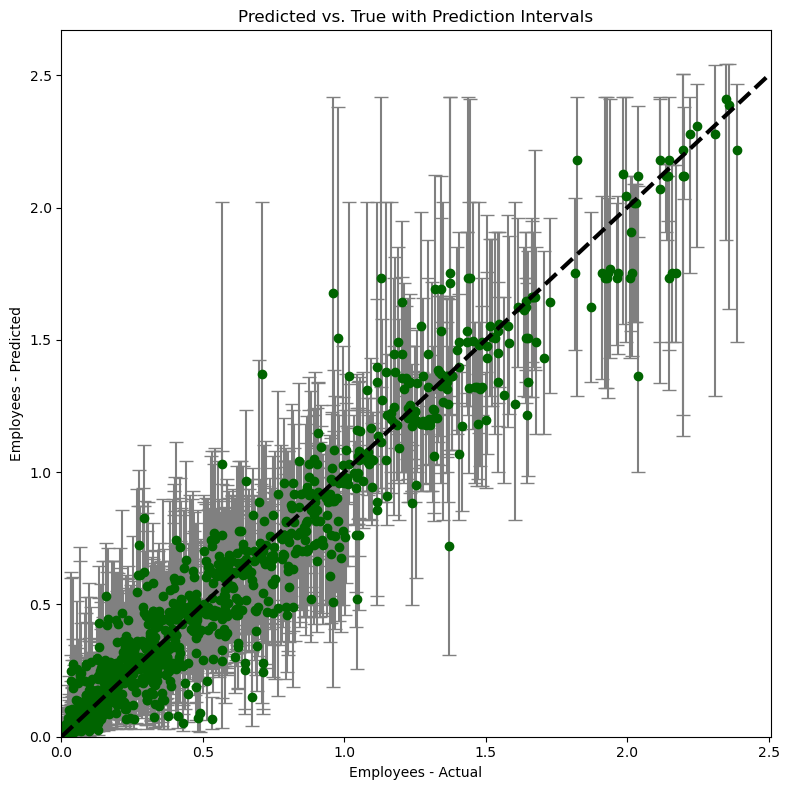

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

# Compute error bar distances safely
lower_errors = np.maximum(predictions["point prediction"] - predictions["lower"], 0)
upper_errors = np.maximum(predictions["upper"] - predictions["point prediction"], 0)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

plt.errorbar(
    predictions["y_true"], predictions["point prediction"],
    yerr=[lower_errors, upper_errors],
    color='darkgreen', ecolor='grey', linestyle='', marker="o", capsize=5
)

ax.axline([0, 0], [1, 1], color="black", linestyle='--', lw=3, zorder=3)
plt.xlim(0)
plt.ylim(0)
plt.xlabel('Employees - Actual')
plt.ylabel('Employees - Predicted')
plt.title("Predicted vs. True with Prediction Intervals")
plt.tight_layout()
plt.show()

#### Error plot (sorted by prediction interval width)

In [29]:
predictions["error"]   = predictions["point prediction"] - predictions["y_true"]

predictions["error_upper"] =   (predictions["upper"] - predictions["point prediction"])
predictions["error_lower"] =  -(predictions["point prediction"]- predictions["lower"])

# sort by total interval width
predictions["interval_width"] = predictions["upper"] - predictions["lower"]
sorted_predictions = predictions.sort_values(by=['interval_width']).reset_index(drop=True)

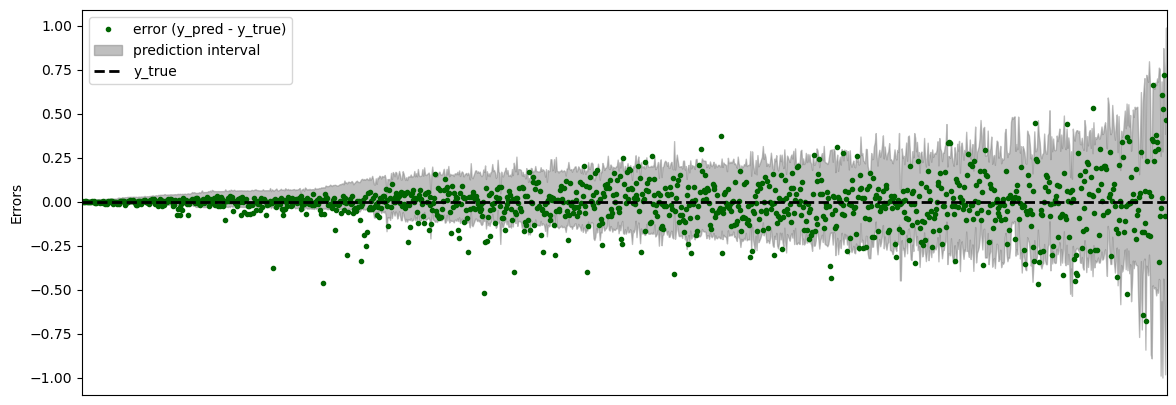

In [30]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(sorted_predictions["error"], 'o', markersize=3, label="error (y_pred - y_true)", color='darkgreen')

plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["error_lower"], 
                 sorted_predictions["error_upper"], 
                 alpha=0.5, color="grey", label="prediction interval")

ax.axline([0, 0], [1, 0], color = "black", linestyle='--', lw=2, zorder=3, label="y_true")
plt.xticks([])
plt.xlim([0, len(sorted_predictions)])
plt.ylabel("Errors", fontsize=10)
plt.legend(loc="upper left", fontsize=10)
plt.show()

Calculate the % of predictions that are within the predicttion interval

In [31]:
# count number of points outside of predicted interval
sorted_predictions["is_outside_range"] = 0
sorted_predictions["is_outside_range"] = sorted_predictions["is_outside_range"].where((
    (sorted_predictions["error"] < sorted_predictions["error_upper"]) & (sorted_predictions["error"] > sorted_predictions["error_lower"]) ), 
    other=1)

print(round(100-(100/len(sorted_predictions))*sorted_predictions["is_outside_range"].sum(),1))

86.5


Now let us calculate the % of prediction intervals that contained the ground truth value

In [32]:
# count number of prediction intervals that actually contain the ground truth value
sorted_predictions["gt_within_PI"] = 0
sorted_predictions["gt_within_PI"] = sorted_predictions["gt_within_PI"].where((
    (sorted_predictions["y_true"] < sorted_predictions["upper"]) & (sorted_predictions["y_true"] > sorted_predictions["lower"]) ), 
    other=1)

print(round(100-(100/len(sorted_predictions))*sorted_predictions["gt_within_PI"].sum(),1))

90.9


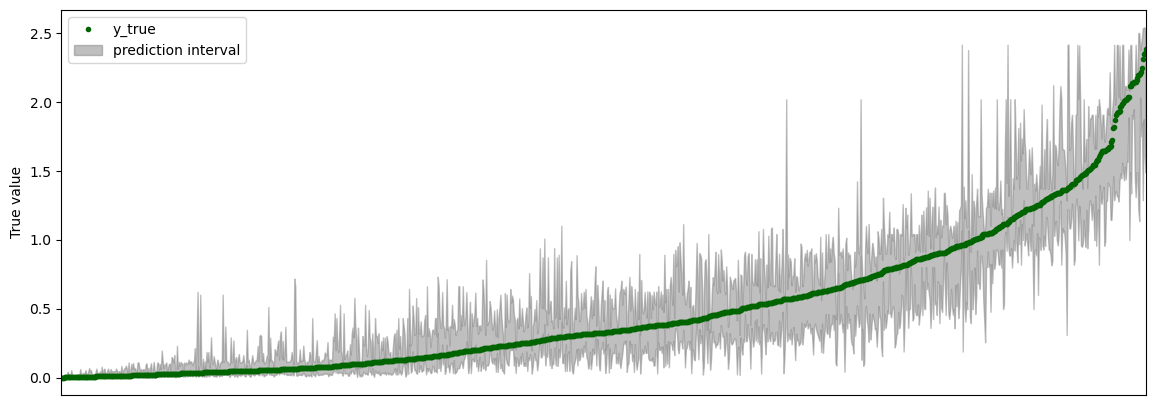

In [33]:
# re-sort for plot
sorted_predictions = predictions.sort_values(by=['y_true']).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(sorted_predictions["y_true"], 'o', markersize=3, label="y_true", color='darkgreen')

plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["lower"], 
                 sorted_predictions["upper"], 
                 alpha=0.5, color="grey", label="prediction interval")

plt.xticks([])
plt.xlim([0, len(sorted_predictions)])
plt.ylabel("True value")
plt.legend(loc="upper left", fontsize=10)
plt.show()

Average prediction interval width

In [34]:
print(round(predictions["interval_width"].mean(),-3))
print(round(predictions["interval_width"].median(),-3))

0.0
0.0


In [35]:
from py_modules import MWIS_metric

MWIS,coverage = MWIS_metric.score(predictions["y_true"],predictions["lower"],predictions["upper"],alpha)
print(f"MWI score           ",round(MWIS,3))
print("Predictions coverage    ", round(coverage*100,1),"%")

MWI score            0.469
Predictions coverage     91.4 %


### Conformal prediction
Let us now add *validity* to the prediction intervals using the [conformalized quantile regression (CQR)](https://arxiv.org/pdf/1905.03222.pdf) technique by Emmanuel Candès and co-workers [3].
This is an inductive technique so we shall now make use of the calibration set that we set aside earlier. First we make our predictions for the lower ($l$) and upper ($u$) quantiles in this calibration dataset, just as before


In [36]:
# calculate lower and upper quantile values of the calibration set
y_pred_lower_upper = qrf.predict(X_calib, quantiles=[alpha/2, 1-alpha/2])

calibration_df = pd.DataFrame(y_calib.values, columns = ['y_true'])
calibration_df["lower"] = y_pred_lower_upper[:,0]
calibration_df["upper"] = y_pred_lower_upper[:,1]

we now calculate the *conformity scores* for each row
$$\large E_i := \max \{l_i - y_{true(i)}, y_{true(i)} - u_i \}$$

In [37]:
a  = (calibration_df["lower"]-calibration_df["y_true"]).values
b  = (calibration_df["y_true"]-calibration_df["upper"]).values
calibration_df["Ei"] = (np.vstack((a, b)).T).max(axis=1)

calibration_df

,y_true,lower,upper,Ei
0,0.484869,0.188647,0.855398,-0.296222
1,0.078094,0.020755,0.111330,-0.033235
2,0.187239,0.047275,0.321184,-0.133945
3,0.133219,0.227706,0.625312,0.094487
4,0.406540,0.243286,1.109005,-0.163254
...,...,...,...,...
964,0.037028,0.020361,0.115278,-0.016667
965,0.525693,0.405688,0.848497,-0.120005
966,0.019947,0.005609,0.046105,-0.014337
967,0.315970,0.071034,0.376585,-0.060615


now we calculate a score $s$ as the following quantile of the $E_i$ values:
$$\large s = \mathrm{quantile} \left( (1-\alpha)(1+1/n) \right) $$
where $n$ is the number of rows in the calibration set

In [38]:
s = calibration_df["Ei"].quantile((1-alpha)*(1+(1/(len(calibration_df)))))
print(s)

-0.001690836792794256


then finally we subtract $s$ from the lower quantile we calculated earlier for the test set, and we add $s$ to the upper quantile

In [39]:
predictions["conformal_lower"] = predictions["lower"] - s
predictions["conformal_upper"] = predictions["upper"] + s

predictions

,y_true,lower,point prediction,upper,error,error_upper,error_lower,interval_width,conformal_lower,conformal_upper
0,0.041787,0.017451,0.053846,0.114961,0.012059,0.061115,-0.036396,0.097510,0.019142,0.113270
1,0.568202,0.146035,0.288026,0.574031,-0.280176,0.286006,-0.141991,0.427996,0.147726,0.572340
2,1.288964,0.955606,1.178977,1.371806,-0.109987,0.192830,-0.223371,0.416200,0.957297,1.370116
3,0.212720,0.087426,0.466126,0.855398,0.253406,0.389272,-0.378699,0.767972,0.089117,0.853707
4,0.006466,0.005609,0.019116,0.053098,0.012650,0.033981,-0.013507,0.047488,0.007300,0.051407
...,...,...,...,...,...,...,...,...,...,...
1206,1.643453,1.385606,1.647383,1.908485,0.003930,0.261102,-0.261777,0.522879,1.387297,1.906794
1207,0.236537,0.198657,0.337259,0.544149,0.100722,0.206889,-0.138602,0.345491,0.200348,0.542458
1208,0.954243,0.518229,0.763428,0.977724,-0.190815,0.214296,-0.245199,0.459494,0.519920,0.976033
1209,0.318063,0.121231,0.318272,0.431364,0.000209,0.113092,-0.197041,0.310132,0.122922,0.429673


now let us take a look at the new coverage

In [40]:
MWIS,coverage = MWIS_metric.score(predictions["y_true"],predictions["conformal_lower"],predictions["conformal_upper"],alpha)
print(f"MWI score           ",round(MWIS,3))
print("Predictions coverage    ", round(coverage*100,1),"%")

MWI score            0.468
Predictions coverage     89.8 %


https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-quantile-py

   Alpha  Pinball Loss
0    0.1      0.017438
1    0.2      0.027528
2    0.3      0.034378
3    0.4      0.038429
4    0.5      0.040546
5    0.6      0.039792
6    0.7      0.037956
7    0.8      0.032440
8    0.9      0.021595
Calculated Mean Bias: 0.010485


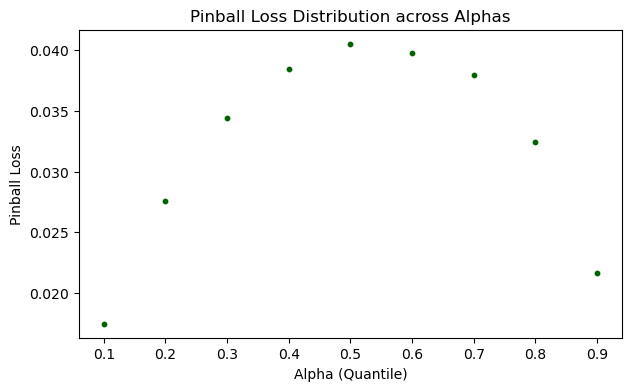

In [41]:
from sklearn.metrics import mean_pinball_loss

y_true = predictions["y_true"]
#y_pred = predictions["point prediction"]

alphas = np.linspace(0.1, 0.9, 9)
loss_list = []

for alpha in alphas:
    y_pred_quantile = qrf.predict(X_test, quantiles=[alpha])
    loss = mean_pinball_loss(y_true, y_pred_quantile, alpha=alpha)
    # loss = mean_pinball_loss(y_true, y_pred, alpha=alpha)
    loss_list.append(loss)
    # print(f"{alpha:<10.1f} | {loss:.6f}")

pinball_loss_df = {'Alpha': alphas,
                   'Pinball Loss': loss_list}

# Calculate the actual Mean Error (Bias)
median_pred = qrf.predict(X_test, quantiles=[0.5])
mean_error = np.mean(y_true - median_pred)
pinball_loss_df = pd.DataFrame(pinball_loss_df)
print(pinball_loss_df)
print(f"Calculated Mean Bias: {mean_error:.6f}")

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.scatter(pinball_loss_df['Alpha'], pinball_loss_df['Pinball Loss'], s=10, color='darkgreen')

ax.set_xlabel('Alpha (Quantile)')
ax.set_ylabel('Pinball Loss')
ax.set_title('Pinball Loss Distribution across Alphas')

plt.show()

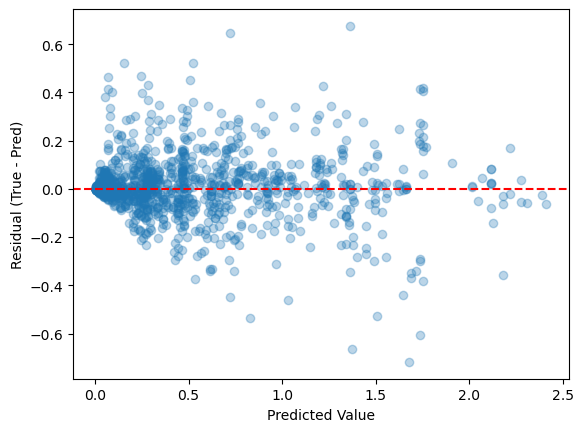

In [42]:
# Plot Residuals vs. Predicted Value (on Calibration or Test data)
residuals = predictions["y_true"] - predictions["point prediction"]
plt.scatter(predictions["point prediction"], residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Value")
plt.ylabel("Residual (True - Pred)")
plt.show()

### **Sub-Task: Train QRF Models for Subsets of Quarterly Data to get Predicted Values for Employment****

In [43]:
X_train_columns = list(X_train.columns)

In [44]:
X_new = quarterly_data[X_train_columns]

In [45]:
# Predict 90% prediction interval (or whatever your original alpha was)
quantiles = [alpha/2, 1 - alpha/2]
pred_new_lower_upper = qrf.predict(X_new, quantiles=quantiles)
pred_new_point = qrf.predict(X_new, quantiles="mean")

In [46]:
# Inflate intervals using conformal score s
pred_new_conformal_lower = pred_new_lower_upper[:, 0] - s
pred_new_conformal_upper = pred_new_lower_upper[:, 1] + s

In [47]:
quarterly_data["Employees_pred_point"] = pred_new_point
quarterly_data["Employees_pred_lower"] = pred_new_conformal_lower
quarterly_data["Employees_pred_upper"] = pred_new_conformal_upper

In [48]:
# Build a classifier to distinguish between X_train and X_new
X_combined = pd.concat([X_train, X_new])
y_combined = [0] * len(X_train) + [1] * len(X_new)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
accuracy = cross_val_score(clf, X_combined, y_combined, cv=5).mean()
print("Classifier accuracy:", accuracy)

Classifier accuracy: 0.6344161333661021


In [50]:
quarterly_data = quarterly_data.dropna(subset=['Employees_pred_point'])

In [51]:
quarterly_data.to_excel('Quarterly Data (with Employees).xlsx')